In [1]:
from gpt2 import GPT, GPTConfig # our GPT class

import math
import time
import tiktoken
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
enc = tiktoken.get_encoding('gpt2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # dynamic device

torch.manual_seed(13) # for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(13)

## Data Loader Lite

In [3]:
class DataLoaderLite:

    def __init__(self, B, T):

        self.B, self.T = B, T

        with open('data/input.txt', 'r') as file:
            text = file.read().replace('\n', '')
        
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long, device=device)

        self.current_batch = 0
        self.number_of_batches = len(self.tokens) // (B * T)

        print(f'Loaded {len(self.tokens)} tokens, {self.number_of_batches} batches of size {B}x{T}')

    
    def next_batch(self):

        B, T = self.B, self.T

        buf = self.tokens[self.current_batch * B * T : (self.current_batch + 1) * B * T + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)

        self.current_batch += 1
        if self.current_batch >= self.number_of_batches:
            self.current_batch = 0
        
        return x, y

## Learning Rate Scheduler

In [4]:
max_lr = 6e-4
min_lr = max_lr / 10
warmup_steps = 10
num_steps = 50
def get_lr(step):
    if step < warmup_steps:
        return min_lr + (max_lr - min_lr) * step / warmup_steps
    elif step < num_steps:
        return min_lr + (max_lr - min_lr) * (1 + math.cos((step - warmup_steps) / (num_steps - warmup_steps) * math.pi)) / 2
    else:
        return min_lr

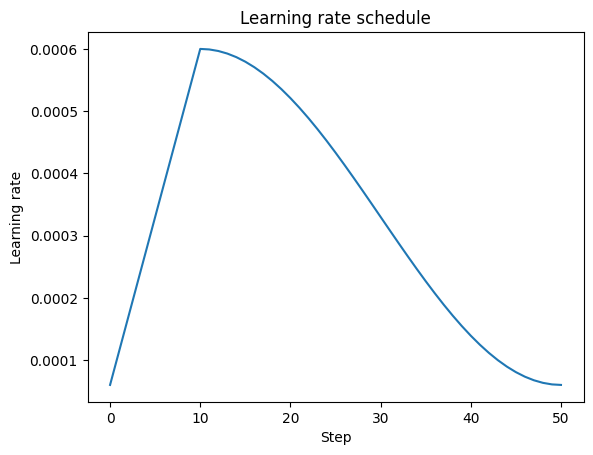

In [5]:
plt.plot([get_lr(step) for step in range(0, num_steps + 1)]);
plt.title('Learning rate schedule');
plt.xlabel('Step');
plt.ylabel('Learning rate');

## Training

In [6]:
model = GPT(GPTConfig(vocab_size=50304)).to(device).train()
model = torch.compile(model)

total_batch_size = 524288
B, T = 4, 1024
assert total_batch_size % (B * T) == 0, 'Total batch size must be divisible by B * T'
grad_accumulation_steps = total_batch_size // (B * T)

data_loader = DataLoaderLite(B, T)
scaler = torch.cuda.amp.GradScaler() # create a gradient scaler for mixed precision training

# Create optimizer with weight decay
param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad} # all the params require grad anyways
weight_decay_params = [p for pn, p in param_dict.items() if p.dim() >= 2]
non_weight_decay_params = [p for pn, p in param_dict.items() if p.dim() < 2]
optim_groups = [
    {'params': weight_decay_params, 'weight_decay': 0.01},
    {'params': non_weight_decay_params, 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optim_groups, lr=1, betas=(0.9, 0.95), eps=1e-8, fused=True)

for step in range(num_steps):
    t0 = time.time()

    loss_accumulator = torch.tensor(0.0, device=device, requires_grad=False)
    optimizer.zero_grad()
    for micro_step in range(grad_accumulation_steps):

        # forward pass
        x, y = data_loader.next_batch()
        with torch.autocast(device_type=device.type, dtype=torch.float16):
            logits, loss = model(x, y)

        # backward pass
        loss = loss / grad_accumulation_steps # loss is averaged over each micro-batch in the batch
        loss_accumulator += loss.detach() # this is preferred over `.item()` since it does not force GPU-CPU sync
        scaler.scale(loss).backward()
    
    # learning rate schedule
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # optimizer step
    scaler.unscale_(optimizer)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()
    
    # track throughput
    torch.cuda.synchronize() # wait for GPU to finish work
    t1 = time.time()
    dt = (t1 - t0) * 1000 # time difference in milliseconds
    throughput = (B * T * grad_accumulation_steps) / (t1 - t0) # tokens per second

    # print stats
    print(f"step {step:4d} | loss {loss_accumulator:.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt:.2f} ms | throughput: {throughput:.2f} tok/s")

Loaded 297884 tokens, 72 batches of size 4x1024
step    0 | loss 10.978139 | lr: 6.0000e-05 | norm: 16.5712 | dt: 52202.80 ms | throughput: 10043.29 tok/s
step    1 | loss 10.102369 | lr: 1.1400e-04 | norm: 6.4550 | dt: 25268.63 ms | throughput: 20748.57 tok/s
step    2 | loss 9.759232 | lr: 1.6800e-04 | norm: 2.5760 | dt: 25297.78 ms | throughput: 20724.66 tok/s
step    3 | loss 9.622756 | lr: 2.2200e-04 | norm: 3.0623 | dt: 25862.73 ms | throughput: 20271.95 tok/s
step    4 | loss 9.364845 | lr: 2.7600e-04 | norm: 1.8434 | dt: 26559.22 ms | throughput: 19740.34 tok/s
step    5 | loss 9.120868 | lr: 3.3000e-04 | norm: 1.8474 | dt: 27252.84 ms | throughput: 19237.92 tok/s
step    6 | loss 8.846601 | lr: 3.8400e-04 | norm: 1.8089 | dt: 27364.27 ms | throughput: 19159.58 tok/s
step    7 | loss 8.519905 | lr: 4.3800e-04 | norm: 1.5765 | dt: 27340.18 ms | throughput: 19176.47 tok/s
step    8 | loss 8.187926 | lr: 4.9200e-04 | norm: 1.4141 | dt: 27321.78 ms | throughput: 19189.38 tok/s
step